In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag

#Para los algoritmos y la bolsa de palabras
# ==============================================================================
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB #NaiveBayes
from sklearn.svm import SVC


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv("Corona_NLP_test.csv")
print(df)

      Idusuario                                              Tweet  \
0             1  TRENDING: New Yorkers encounter empty supermar...   
1             2  When I couldn't find hand sanitizer at Fred Me...   
2             3  Find out how you can protect yourself and love...   
3             4  #Panic buying hits #NewYork City as anxious sh...   
4             5  #toiletpaper #dunnypaper #coronavirus #coronav...   
...         ...                                                ...   
3793       3794  Meanwhile In A Supermarket in Israel -- People...   
3794       3795  Did you panic buy a lot of non-perishable item...   
3795       3796  Asst Prof of Economics @cconces was on @NBCPhi...   
3796       3797  Gov need to do somethings instead of biar je r...   
3797       3798  I and @ForestandPaper members are committed to...   

             Sentimiento  
0     Extremely Negative  
1               Positive  
2     Extremely Positive  
3               Negative  
4                Neutral

In [4]:
sen_bef= df.Sentimiento.value_counts()
sen_bef

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentimiento, dtype: int64

([<matplotlib.patches.Wedge at 0xc59875cb50>,
 [Text(0.716776929332184, 0.8344044784018874, 'Negative'),
  Text(-0.8848645623268316, 0.653463622811664, 'Positive'),
  Text(-0.8694938694526417, -0.6737806846328207, 'Neutral'),
  Text(0.10538503528793892, -1.0949401784286483, 'Extremely Positive'),
  Text(0.970729275642409, -0.5173825213618685, 'Extremely Negative')],
 [Text(0.39096923418119117, 0.4551297154919385, '27.4%'),
  Text(-0.4826533976328172, 0.3564347033518167, '24.9%'),
  Text(-0.47426938333780455, -0.3675167370724476, '16.3%'),
  Text(0.057482746520693954, -0.5972400973247172, '15.8%'),
  Text(0.5294886958049503, -0.28220864801556456, '15.6%')])

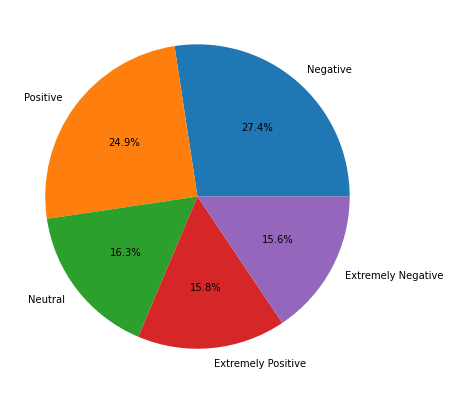

In [5]:
plt.figure(figsize=(10, 7))
plt.pie(sen_bef, labels = sen_bef.index, autopct='%1.1f%%', shadow=False)

In [3]:
#Definimos una funcion para limpiar los textos
def clean(text):
    ps = PorterStemmer()
    rex = re.compile(r'\s+')
    text = text.lower()
    text =re.sub("([\(\[]).*?([\)\]]___)", "\g<1>\g<2>", text)
    text = ''.join((x for x in text if not x.isdigit()))
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"_\S+", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"http\S+", "", text)
    text = rex.sub(' ', text)
    return text

In [8]:
prue= df.iloc[0][1]
#print(prue)
prue= clean(prue)
print(prue)

trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as shoppers stock up 


In [4]:
# Limpiamos los textos 
df['Cleaned Text'] = df['Tweet'].apply(clean)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...


In [5]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['Text tagged'] = df['Cleaned Text'].apply(token_stop_pos)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou..."
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize..."
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]"
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ..."
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin..."


In [6]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
df['Lemma'] = df['Text tagged'].apply(lemmatize)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...


Análisis de sentimiento con TextBlob

In [7]:
from textblob import TextBlob
# Función para obtener la polaridad
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# Función para realizar la clasificación 
def analysis(score):
    if score <= -0.5:
        return 'Extremely Negative'
    elif score > -0.5 and score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0 and score < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

In [11]:
a= df.iloc[3][5]
print(a)

  buy hit city anxious shopper stock foodampmedical supply worker become st confirm patient staged event


In [94]:
a= df.iloc[0][5]
print(a)

  trend new yorkers encounter empty supermarket shelf picture wegmans brooklyn soldout online grocer foodkick maxdelivery shopper stock


In [12]:
ap= getPolarity(a)
print(ap)

-0.25


In [13]:
analysis(ap)

'Negative'

In [8]:
df['Polarity'] = df['Lemma'].apply(getPolarity) 
df['SentimientoTextBlob'] = df['Polarity'].apply(analysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative


In [14]:
sen_Blob= df.SentimientoTextBlob.value_counts()
sen_Blob

Positive              1511
Negative              1035
Neutral                947
Extremely Positive     196
Extremely Negative     109
Name: SentimientoTextBlob, dtype: int64

In [ ]:
#Utilizando Vader

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Funcion para calcular el sentimiento vader  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
#Funcion para realizar la clasificación
def vader_analysis(compound):
    if compound <= -0.5:
        return 'Extremely Negative'
    elif compound > -0.5 and compound < 0:
        return 'Negative'
    elif compound == 0:
        return 'Neutral'
    elif compound > 0 and compound < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

In [102]:
a= df.iloc[4][5]
print(a)

  one week everyone buying baby milk powder next everyone buy toilet paper


In [103]:
av= vadersentimentanalysis(a)
av

0.0

In [10]:
df['Vader Polarity'] = df['Lemma'].apply(vadersentimentanalysis)
df['SentimientoVader'] = df['Vader Polarity'].apply(vader_analysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral


In [18]:
sen_Vader= df.SentimientoVader.value_counts()
sen_Vader

Negative              854
Positive              847
Extremely Positive    834
Extremely Negative    679
Neutral               584
Name: SentimientoVader, dtype: int64

In [17]:
#Análisis usuando SentiWordnet

In [11]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 'Neutral'
    if sentiment <= -0.5:
        return 'Extremely Negative'
    elif sentiment > -0.5 and sentiment < 0:
        return 'Negative'
    elif sentiment == 0:
        return 'Neutral'
    elif sentiment > 0 and sentiment < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [111]:
a= df.iloc[4][4]
print(a)

[('one', None), ('week', 'n'), ('everyone', 'n'), ('buying', 'n'), ('baby', 'n'), ('milk', 'n'), ('powder', 'v'), ('next', 'a'), ('everyone', 'n'), ('buying', 'v'), ('toilet', 'a'), ('paper', 'n')]


In [112]:
aw= sentiwordnetanalysis(a)
aw

'Neutral'

In [12]:
df['SentimientoSWN'] = df['Text tagged'].apply(sentiwordnetanalysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader,SentimientoSWN
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative,Extremely Positive
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive,Negative
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative,Positive
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral,Neutral


In [21]:
sen_SWN= df.SentimientoSWN.value_counts()
sen_SWN

Extremely Positive    1107
Positive               798
Extremely Negative     749
Negative               591
Neutral                553
Name: SentimientoSWN, dtype: int64

In [13]:
#Datos finales
df

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader,SentimientoSWN
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative,Extremely Positive
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive,Negative
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative,Positive
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile in a supermarket in israel people da...,"[(meanwhile, r), (supermarket, n), (israel, a)...",meanwhile supermarket israel people dance si...,0.227273,Positive,0.5574,Extremely Positive,Extremely Positive
3794,3795,Did you panic buy a lot of non-perishable item...,Negative,did you panic buy a lot of nonperishable items...,"[(panic, v), (buy, v), (lot, n), (nonperishabl...",panic buy lot nonperishable item echo need f...,0.500000,Extremely Positive,-0.2500,Negative,Negative
3795,3796,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof of economics cconces was on nbcphila...,"[(asst, a), (prof, n), (economics, n), (cconce...",asst prof economics cconces nbcphiladelphia ...,0.000000,Neutral,0.0000,Neutral,Neutral
3796,3797,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need to do somethings instead of biar je r...,"[(gov, n), (need, v), (somethings, n), (instea...",gov need somethings instead biar je rakyat a...,-0.700000,Extremely Negative,-0.7650,Extremely Negative,Extremely Negative


([<matplotlib.patches.Wedge at 0xc5b522d1f0>,
 [Text(0.8367714894262479, 0.7140122369283168, 'Negative'),
  Text(-0.5680230059539431, 0.9419924971606977, 'Positive'),
  Text(-1.0285923220491142, -0.3898689972562723, 'Extremely Positive'),
  Text(0.04729952985042275, -1.098982599714813, 'Extremely Negative'),
  Text(0.974131699162296, -0.5109475831112016, 'Neutral')],
 [Text(0.456420812414317, 0.3894612201427183, '22.5%'),
  Text(-0.30983073052033255, 0.5138140893603804, '22.3%'),
  Text(-0.561050357481335, -0.2126558166852394, '22.0%'),
  Text(0.025799743554776045, -0.599445054389898, '17.9%'),
  Text(0.5313445631794341, -0.278698681697019, '15.4%')])

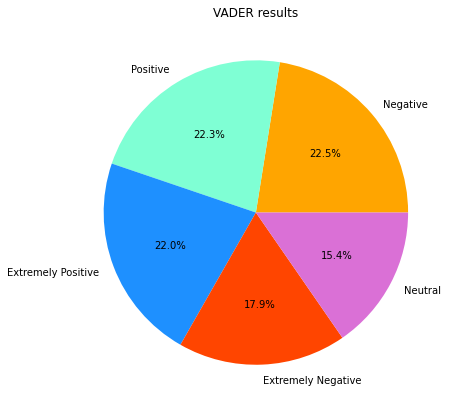

In [23]:
plt.figure(figsize=(15,7))
plt.title("VADER results")
colores = ["Orange","Aquamarine","Dodgerblue","Orangered","Orchid"]
plt.pie(sen_Vader, labels = sen_Vader.index, autopct='%1.1f%%', colors= colores,shadow=False)

([<matplotlib.patches.Wedge at 0xc5b54c8280>,
 [Text(0.6701788608908433, 0.872273061841905, 'Extremely Positive'),
  Text(-0.8755884125463829, 0.6658415215458595, 'Positive'),
  Text(-0.8891693557878838, -0.6475938980007145, 'Extremely Negative'),
  Text(0.18294322687775372, -1.0846804947723339, 'Negative'),
  Text(0.98691189730594, -0.48580336243792094, 'Neutral')],
 [Text(0.36555210594046, 0.47578530645922085, '29.1%'),
  Text(-0.4775936795707542, 0.3631862844795597, '21.0%'),
  Text(-0.4850014667933911, -0.35323303527311695, '19.7%'),
  Text(0.09978721466059293, -0.5916439062394547, '15.6%'),
  Text(0.5383155803486944, -0.26498365223886594, '14.6%')])

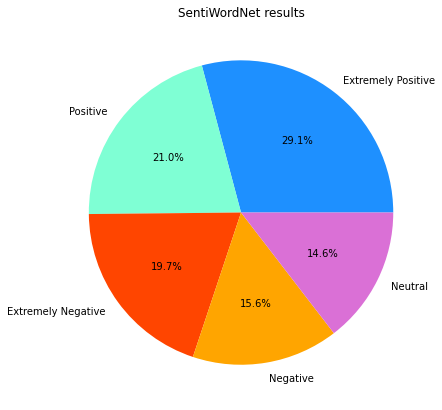

In [24]:
plt.figure(figsize=(15,7))
plt.title("SentiWordNet results")
colores = ["Dodgerblue","Aquamarine","Orangered","Orange","Orchid"]
plt.pie(sen_SWN, labels = sen_SWN.index, autopct='%1.1f%%', colors= colores, shadow=False)

([<matplotlib.patches.Wedge at 0x11d128dc0>,
 [Text(0.34873312442622484, 1.0432570191127033, 'Positive'),
  Text(-1.0754297922665315, -0.23119420820073597, 'Negative'),
  Text(0.30529956768075056, -1.0567838823401627, 'Neutral'),
  Text(1.0358229158466128, -0.37023085636805225, 'Extremely Positive'),
  Text(1.095532012147554, -0.09904347711955433, 'Extremely Negative')],
 [Text(0.1902180678688499, 0.5690492831523836, '39.7%'),
  Text(-0.5865980685090171, -0.12610593174585596, '27.3%'),
  Text(0.16652703691677304, -0.5764275721855432, '24.9%'),
  Text(0.5649943177345159, -0.20194410347348302, '5.2%'),
  Text(0.5975629157168476, -0.054023714792484176, '2.9%')])

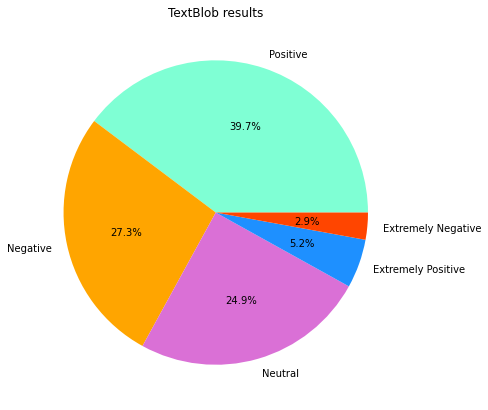

In [24]:
plt.figure(figsize=(15,7))
colores = ["Aquamarine","Orange","Orchid","Dodgerblue","Orangered"]
plt.title("TextBlob results")
plt.pie(sen_Blob, labels = sen_Blob.index, autopct='%1.1f%%',colors= colores, shadow=False)

([<matplotlib.patches.Wedge at 0xc5b52bb130>,
 [Text(0.716776929332184, 0.8344044784018874, 'Negative'),
  Text(-0.8848645623268316, 0.653463622811664, 'Positive'),
  Text(-0.8694938694526417, -0.6737806846328207, 'Neutral'),
  Text(0.10538503528793892, -1.0949401784286483, 'Extremely Positive'),
  Text(0.970729275642409, -0.5173825213618685, 'Extremely Negative')],
 [Text(0.39096923418119117, 0.4551297154919385, '27.4%'),
  Text(-0.4826533976328172, 0.3564347033518167, '24.9%'),
  Text(-0.47426938333780455, -0.3675167370724476, '16.3%'),
  Text(0.057482746520693954, -0.5972400973247172, '15.8%'),
  Text(0.5294886958049503, -0.28220864801556456, '15.6%')])

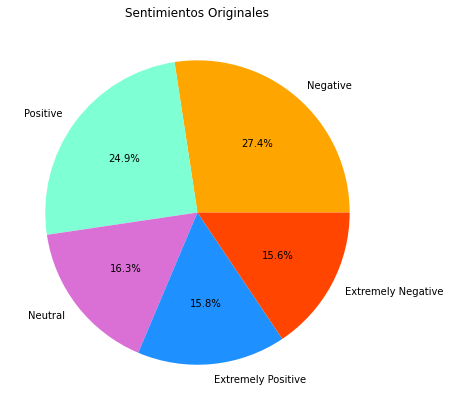

In [25]:
plt.figure(figsize=(15, 7))
plt.title("Sentimientos Originales")
colores = ["Orange","Aquamarine","Orchid","Dodgerblue","Orangered"]
plt.pie(sen_bef, labels = sen_bef.index, autopct='%1.1f%%',colors= colores, shadow=False)

In [26]:
Info= [[599, 947, 619, 1041, 592],[197, 1509, 947, 1036, 109], [834, 847, 584, 853, 680], [1107, 799, 553, 590, 749]]
columnas= ["Extremely Positive", "Positive", "Neutral", "Negative","Extremely Negative"]
Filas= ["Original", "Text Blob", "Vader", "SWN"]
Sentimientos= pd.DataFrame(Info, columns= columnas, index= Filas)
Sentimientos

,Extremely Positive,Positive,Neutral,Negative,Extremely Negative
Original,599,947,619,1041,592
Text Blob,197,1509,947,1036,109
Vader,834,847,584,853,680
SWN,1107,799,553,590,749


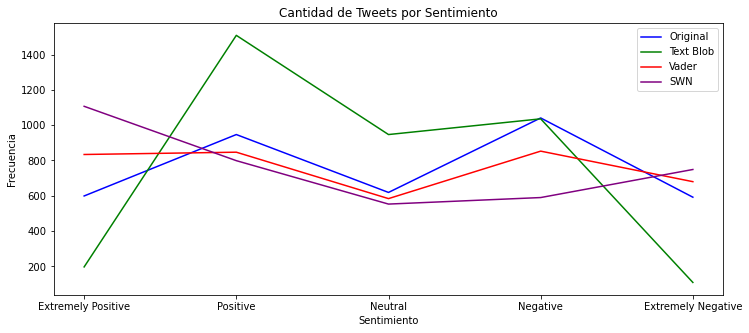

In [27]:
fig= plt.figure(figsize=(12,5))
plt.plot( columnas , Info[0], c= "blue", linestyle='-', label= "Original")
plt.plot( columnas , Info[1], c= "Green", linestyle='-', label= "Text Blob")
plt.plot( columnas , Info[2], c= "Red", linestyle='-', label= "Vader")
plt.plot( columnas , Info[3], c= "Purple", linestyle='-', label= "SWN")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.title("Cantidad de Tweets por Sentimiento")
plt.legend(loc = "upper right")
plt.show()

In [15]:
fin_data = pd.DataFrame(df[['Tweet', 'Lemma', 'Sentimiento','SentimientoTextBlob','SentimientoVader','SentimientoSWN']])

In [16]:
fin_data

,Tweet,Lemma,Sentimiento,SentimientoTextBlob,SentimientoVader,SentimientoSWN
0,TRENDING: New Yorkers encounter empty supermar...,trend new yorkers encounter empty supermarke...,Extremely Negative,Positive,Negative,Positive
1,When I couldn't find hand sanitizer at Fred Me...,couldnt find hand sanitizer fred meyer turn ...,Positive,Neutral,Negative,Extremely Positive
2,Find out how you can protect yourself and love...,find protect love one,Extremely Positive,Extremely Positive,Extremely Positive,Negative
3,#Panic buying hits #NewYork City as anxious sh...,buy hit city anxious shopper stock foodampme...,Negative,Negative,Negative,Positive
4,#toiletpaper #dunnypaper #coronavirus #coronav...,one week everyone buying baby milk powder ne...,Neutral,Negative,Neutral,Neutral
...,...,...,...,...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,meanwhile supermarket israel people dance si...,Positive,Positive,Extremely Positive,Extremely Positive
3794,Did you panic buy a lot of non-perishable item...,panic buy lot nonperishable item echo need f...,Negative,Extremely Positive,Negative,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,asst prof economics cconces nbcphiladelphia ...,Neutral,Neutral,Neutral,Neutral
3796,Gov need to do somethings instead of biar je r...,gov need somethings instead biar je rakyat a...,Extremely Negative,Extremely Negative,Extremely Negative,Extremely Negative


In [17]:
#obtener matriz de frecuencias
count_vector = CountVectorizer()
count_vector.fit(fin_data['Lemma'])
names = count_vector.get_feature_names()

doc_array = count_vector.transform(fin_data['Lemma']).toarray()
doc_array
#Matriz de Frecuencias
frequency_matrix = pd.DataFrame(data=doc_array, columns=names)
frequency_matrix

,aamiin,aapl,abajam,abandon,abc,abeg,abid,abide,abiity,ability,...,zombie,zombieapocalypse,zombieland,zoo,zoom,zsl,zypisfy,zásobovány,zásoby,zástupce
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Utilizando 5 Clases

In [18]:
#Convertimos las clases en numeros
fin_data['Sentimiento'] = fin_data.Sentimiento.map({'Neutral':0, 'Positive':1, 'Extremely Positive':3, 'Negative':2, 'Extremely Negative':4})
fin_data['SentimientoTextBlob'] = fin_data.SentimientoTextBlob.map({'Neutral':0, 'Positive':1, 'Extremely Positive':3, 'Negative':2, 'Extremely Negative':4})
fin_data['SentimientoVader'] = fin_data.SentimientoVader.map({'Neutral':0, 'Positive':1, 'Extremely Positive':3, 'Negative':2, 'Extremely Negative':4})
fin_data['SentimientoSWN'] = fin_data.SentimientoSWN.map({'Neutral':0, 'Positive':1, 'Extremely Positive':3, 'Negative':2, 'Extremely Negative':4})
print(fin_data)

                                                  Tweet  \
0     TRENDING: New Yorkers encounter empty supermar...   
1     When I couldn't find hand sanitizer at Fred Me...   
2     Find out how you can protect yourself and love...   
3     #Panic buying hits #NewYork City as anxious sh...   
4     #toiletpaper #dunnypaper #coronavirus #coronav...   
...                                                 ...   
3793  Meanwhile In A Supermarket in Israel -- People...   
3794  Did you panic buy a lot of non-perishable item...   
3795  Asst Prof of Economics @cconces was on @NBCPhi...   
3796  Gov need to do somethings instead of biar je r...   
3797  I and @ForestandPaper members are committed to...   

                                                  Lemma  Sentimiento  \
0       trend new yorkers encounter empty supermarke...            4   
1       couldnt find hand sanitizer fred meyer turn ...            1   
2                                 find protect love one            3   
3  

In [19]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['Sentimiento'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950


In [21]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

In [22]:
predictions = naive_bayes.predict(testing_data)
print(predictions)
print(y_test)

[2 2 1 1 4 2 2 2 2 2 3 1 2 1 1 2 2 2 2 2 1 2 1 0 2 1 3 2 3 3 1 2 2 3 2 1 2
 2 2 1 1 1 1 1 1 2 1 1 3 1 1 2 3 2 1 1 2 3 1 1 0 2 1 2 1 2 1 1 1 1 4 2 2 1
 2 1 1 2 2 2 2 2 2 2 1 2 3 1 1 1 2 2 3 2 3 2 3 3 2 4 4 2 1 3 2 1 4 2 1 3 3
 1 2 1 1 1 1 2 2 1 1 4 1 1 2 2 2 1 3 1 1 2 2 2 2 1 0 1 2 1 0 4 2 1 2 3 1 2
 3 4 0 2 2 2 2 0 3 1 2 3 1 2 2 1 1 2 1 2 2 3 3 1 2 4 2 1 2 4 1 0 2 2 2 1 1
 2 4 1 2 1 1 2 2 2 2 1 2 1 4 2 2 2 2 2 1 1 2 0 3 3 1 4 2 2 2 1 2 1 1 3 2 3
 2 2 2 3 2 4 1 2 2 1 0 1 1 2 3 3 1 1 1 2 4 3 2 1 4 2 2 1 2 2 2 2 2 2 1 1 1
 3 1 4 1 1 2 4 2 2 2 0 1 1 0 2 2 1 2 1 2 2 1 2 4 4 2 2 2 2 2 1 2 2 1 2 2 2
 1 2 2 2 2 2 2 4 0 4 2 2 2 2 3 2 2 2 0 2 1 1 2 2 4 1 2 2 2 4 1 2 1 2 3 2 2
 1 1 1 1 2 2 3 1 1 2 1 2 3 3 2 2 3 4 1 1 2 1 1 2 1 2 1 4 4 1 1 2 0 3 1 3 2
 0 2 4 3 2 2 0 2 2 1 1 1 1 2 3 2 4 2 1 1 3 2 1 2 1 1 2 0 1 1 2 3 2 3 1 2 1
 1 2 3 4 2 2 1 1 1 1 4 1 2 2 1 1 2 1 3 3 2 2 2 1 3 1 1 4 1 2 2 1 2 3 2 3 2
 1 2 2 2 2 1 4 2 1 2 2 2 1 2 2 2 1 1 4 2 2 2 2 3 2 2 1 4 1 2 2 2 1 2 4 1 2
 2 1 2 4 1 1 2 3 3 2 1 1 

Aciertos: 371
Exactitud:  0.39052631578947367
Precision  0.43348983840769845
Sensibilidad:  0.39052631578947367
F1 score:  0.38319589804562787
Matriz de confusion:


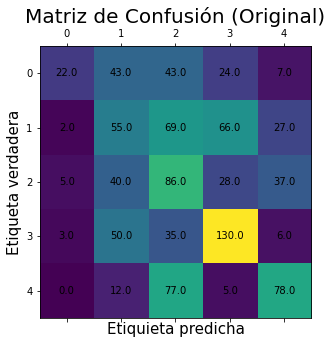

In [25]:
#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión (Original)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 530
Exactitud:  0.5578947368421052
Precision  0.603985903007453
Sensibilidad:  0.5578947368421052
F1 score:  0.5029904256341607
Matriz de confusion:


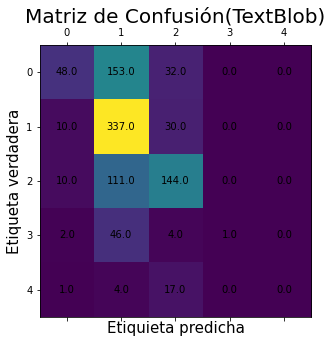

In [26]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoTextBlob'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(TextBlob)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 371
Exactitud:  0.39052631578947367
Precision  0.43348983840769845
Sensibilidad:  0.39052631578947367
F1 score:  0.38319589804562787
Matriz de confusion:


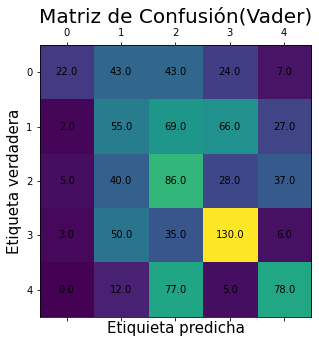

In [27]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoVader'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Vader)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 382
Exactitud:  0.40210526315789474
Precision  0.3989473344250187
Sensibilidad:  0.40210526315789474
F1 score:  0.34781989790021267
Matriz de confusion:


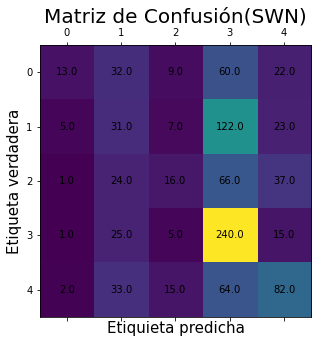

In [28]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoSWN'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(SWN)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


In [ ]:
#Utilizando SVM

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 439
Exatitud:  0.46210526315789474
Precision:  0.48138258553028196
Sensibilidad:  0.46210526315789474
F1 score:  0.46086102647939003


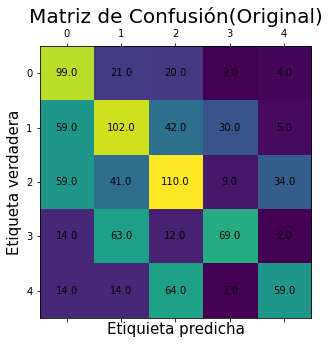

In [29]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['Sentimiento'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Original)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 657
Exatitud:  0.6915789473684211
Precision:  0.6955737910043778
Sensibilidad:  0.6915789473684211
F1 score:  0.6865923305103517


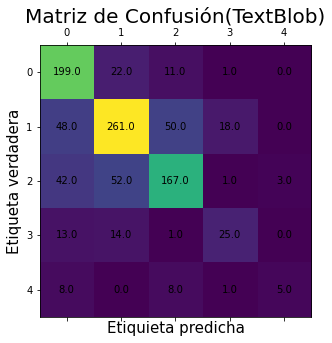

In [31]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoTextBlob'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(TextBlob)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 426
Exatitud:  0.44842105263157894
Precision:  0.4664738072193819
Sensibilidad:  0.44842105263157894
F1 score:  0.44834801813528186


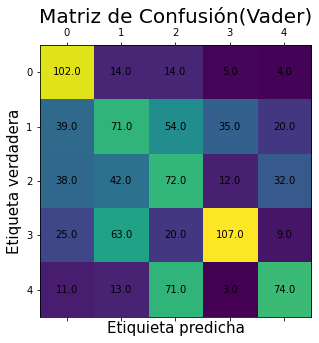

In [32]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoVader'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Vader)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 402
Exatitud:  0.4231578947368421
Precision:  0.45406518526683964
Sensibilidad:  0.4231578947368421
F1 score:  0.43096921455659126


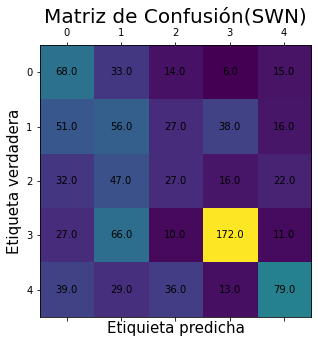

In [33]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoSWN'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(SWN)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

In [ ]:
#REDUCIENDO EL NUMERO DE CLASES A 3

In [34]:
fin_data = pd.DataFrame(df[['Tweet', 'Lemma', 'Sentimiento','SentimientoTextBlob','SentimientoVader','SentimientoSWN']])
#Reducimos las calses a 3
fin_data['Sentimiento'] = fin_data.Sentimiento.map({'Neutral':0, 'Positive':1, 'Extremely Positive':1, 'Negative':2, 'Extremely Negative':2})
fin_data['SentimientoTextBlob'] = fin_data.SentimientoTextBlob.map({'Neutral':0, 'Positive':1, 'Extremely Positive':1, 'Negative':2, 'Extremely Negative':2})
fin_data['SentimientoVader'] = fin_data.SentimientoVader.map({'Neutral':0, 'Positive':1, 'Extremely Positive':1, 'Negative':2, 'Extremely Negative':2})
fin_data['SentimientoSWN'] = fin_data.SentimientoSWN.map({'Neutral':0, 'Positive':1, 'Extremely Positive':1, 'Negative':2, 'Extremely Negative':2})
print(fin_data)

                                                  Tweet  \
0     TRENDING: New Yorkers encounter empty supermar...   
1     When I couldn't find hand sanitizer at Fred Me...   
2     Find out how you can protect yourself and love...   
3     #Panic buying hits #NewYork City as anxious sh...   
4     #toiletpaper #dunnypaper #coronavirus #coronav...   
...                                                 ...   
3793  Meanwhile In A Supermarket in Israel -- People...   
3794  Did you panic buy a lot of non-perishable item...   
3795  Asst Prof of Economics @cconces was on @NBCPhi...   
3796  Gov need to do somethings instead of biar je r...   
3797  I and @ForestandPaper members are committed to...   

                                                  Lemma  Sentimiento  \
0       trend new yorkers encounter empty supermarke...            2   
1       couldnt find hand sanitizer fred meyer turn ...            1   
2                                 find protect love one            1   
3  

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 630
Exactitud:  0.6631578947368421
Precision  0.6604487334327802
Sensibilidad:  0.6631578947368421
F1 score:  0.6271351485260005
Matriz de confusion:


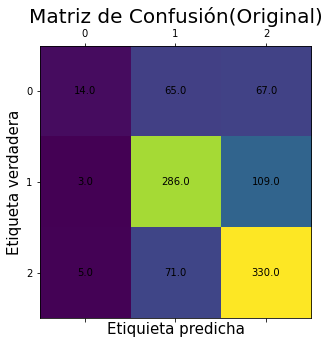

In [35]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['Sentimiento'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Original)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 583
Exactitud:  0.6136842105263158
Precision  0.6422307627964289
Sensibilidad:  0.6136842105263158
F1 score:  0.5721215537672834
Matriz de confusion:


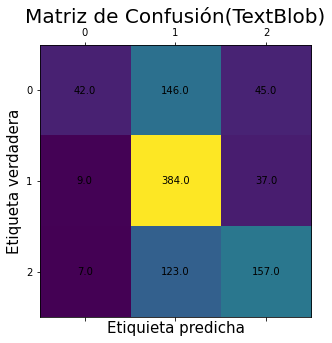

In [36]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoTextBlob'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(TextBlob)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 613
Exactitud:  0.6452631578947369
Precision  0.6643108443635022
Sensibilidad:  0.6452631578947369
F1 score:  0.6130758977631776
Matriz de confusion:


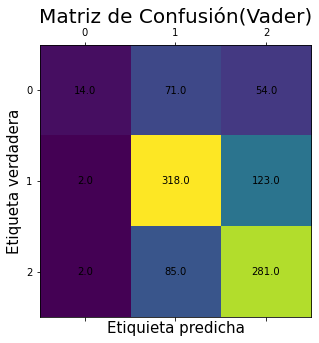

In [37]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoVader'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Vader)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 586
Exactitud:  0.6168421052631579
Precision  0.6122507538854665
Sensibilidad:  0.6168421052631579
F1 score:  0.5664731414686801
Matriz de confusion:


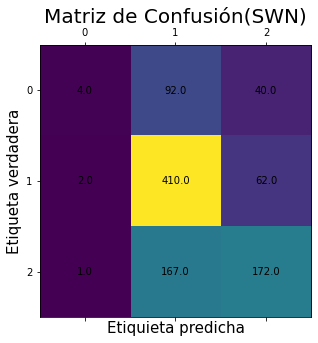

In [38]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoSWN'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(predictions):
  if predictions[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exactitud: ', format(accuracy_score(y_test, predictions)))
print('Precision ', format(precision_score(y_test, predictions, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, predictions, average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))
print('Matriz de confusion:')
cm= confusion_matrix(y_test, predictions)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(SWN)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


In [46]:
#UTILIZANDO MAQUINA DE VECTORES DE SOPORTE

SVC(decision_function_shape='ovo', kernel='linear')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 647
Exatitud:  0.6810526315789474
Precision:  0.7106844998810845
Sensibilidad:  0.6810526315789474
F1 score:  0.6900617756834218


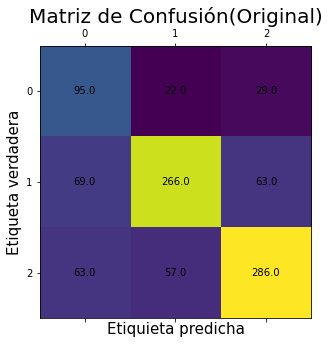

In [39]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['Sentimiento'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)


#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Original)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 707
Exatitud:  0.7442105263157894
Precision:  0.7514755049043415
Sensibilidad:  0.7442105263157894
F1 score:  0.7442758691998774


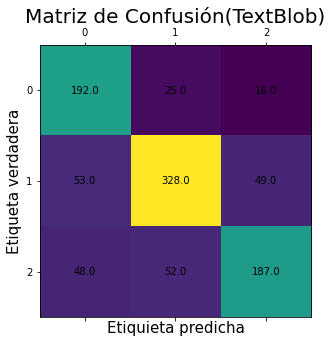

In [40]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoTextBlob'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)


#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(TextBlob)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 672
Exatitud:  0.7073684210526315
Precision:  0.7252355711584071
Sensibilidad:  0.7073684210526315
F1 score:  0.7107740118426055


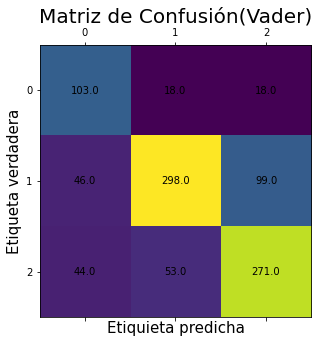

In [41]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoVader'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)


#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(Vader)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Number of rows in the total set: 3798
Number of rows in the training set: 2848
Number of rows in the test set: 950
Aciertos: 604
Exatitud:  0.6357894736842106
Precision:  0.6551901091596375
Sensibilidad:  0.6357894736842106
F1 score:  0.6425371021230528


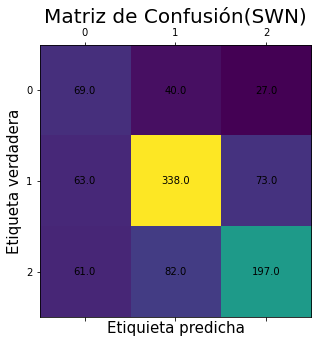

In [42]:
# Dividir los datos en conjunto de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['SentimientoSWN'], random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(x_train.shape[0]))
print('Number of rows in the test set: {}'.format(x_test.shape[0]))

training_data = count_vector.fit_transform(x_train)
testing_data = count_vector.transform(x_test)


#Utilizando Maquina de vectores de soporte
clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(training_data, y_train)

y_pred = clf.predict(testing_data)

#Numero de aciertos
h=0
aciertos= 0
while h < len(y_pred):
  if y_pred[h] == y_test.iloc[h]:
    aciertos= aciertos + 1
  h=h+1
print("Aciertos:",aciertos)

#Eficencia del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print('Exatitud: ', format(accuracy_score(y_test, y_pred)))
print('Precision: ', format(precision_score(y_test, y_pred, average='weighted')))
print('Sensibilidad: ', format(recall_score(y_test, y_pred, average='weighted')))
print('F1 score: ', format(f1_score(y_test, y_pred, average='weighted')))
cm= confusion_matrix(y_test, y_pred)
fig, ax= plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title('Matriz de Confusión(SWN)', fontsize= 20)
plt.ylabel('Etiqueta verdadera', fontsize = 15)
plt.xlabel('Etiquieta predicha', fontsize= 15)
for(i,j), z in np.ndenumerate(cm):
  ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

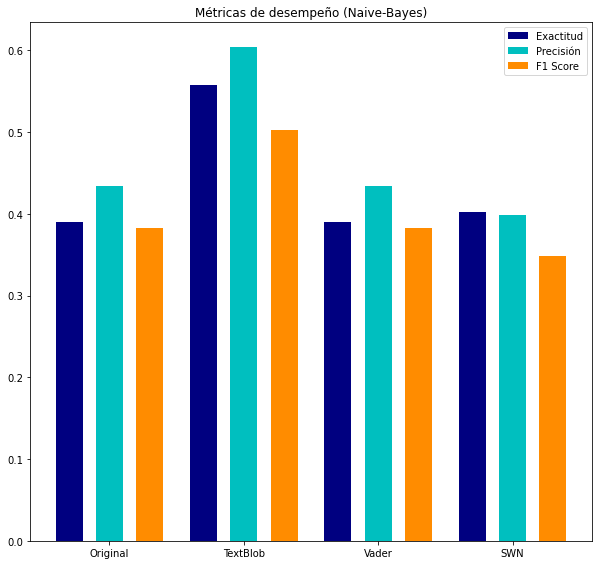

In [49]:
indices = ['Original', 'TextBlob', 'Vader', 'SWN']

Exactitud = [0.3905, 0.5578, 0.3905, 0.4021]
Precision= [0.4334, 0.6039, 0.4334 ,0.3989]
F1= [0.3831, 0.5029, 0.3831, 0.3478]

numero_de_grupos = len(Exactitud)
indice_barras = np.arange(numero_de_grupos)

plt.figure(figsize=(12, 8))
plt.bar(indice_barras, Exactitud, 0.2, label="Exactitud", color="navy")
plt.bar(indice_barras + 0.3, Precision, 0.2, label="Precisión", color="c")
plt.bar(indice_barras + 0.6, F1, 0.2, label="F1 Score", color="darkorange")
plt.xticks(indice_barras + 0.3, ('Original', 'TextBlob', 'Vader', 'SWN'))

plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

plt.title('Métricas de desempeño (Naive-Bayes)')

plt.show()

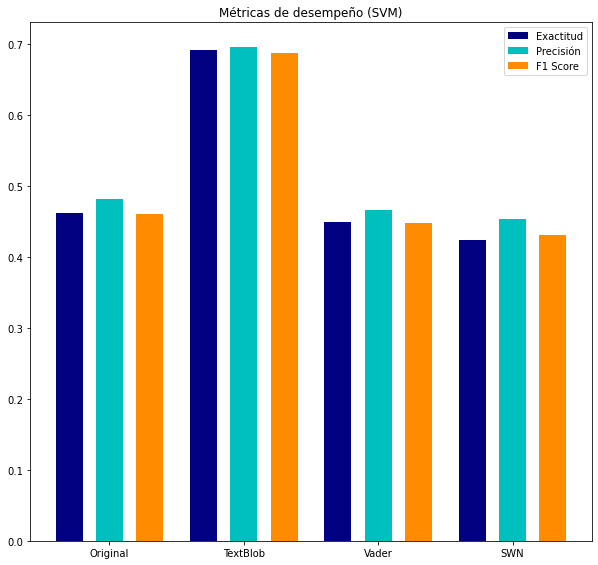

In [50]:
indices = ['Original', 'TextBlob', 'Vader', 'SWN']

Exactitud = [0.4621, 0.6915, 0.4484, 0.4231]
Precision= [0.4813,0.6955, 0.4664, 0.4540]
F1= [0.4608, 0.6865, 0.4483, 0.4309]

numero_de_grupos = len(Exactitud)
indice_barras = np.arange(numero_de_grupos)

plt.figure(figsize=(12, 8))
plt.bar(indice_barras, Exactitud, 0.2, label="Exactitud", color="navy")
plt.bar(indice_barras + 0.3, Precision, 0.2, label="Precisión", color="c")
plt.bar(indice_barras + 0.6, F1, 0.2, label="F1 Score", color="darkorange")
plt.xticks(indice_barras + 0.3, ('Original', 'TextBlob', 'Vader', 'SWN'))

plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

plt.title('Métricas de desempeño (SVM)')

plt.show()

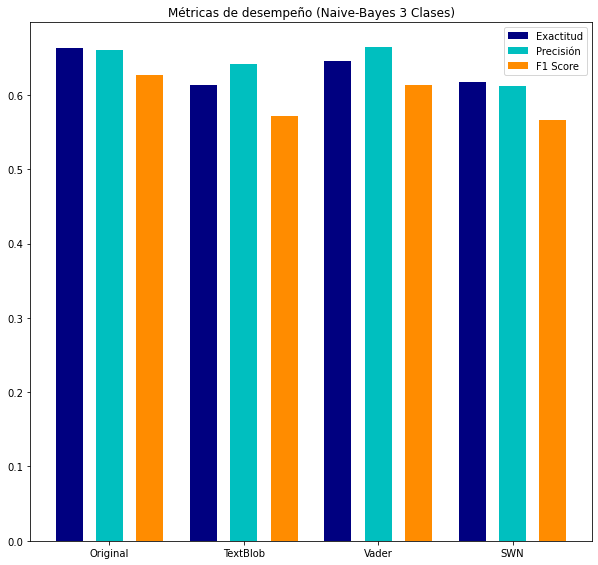

In [51]:
indices = ['Original', 'TextBlob', 'Vader', 'SWN']

Exactitud = [0.6631,0.6136, 0.6452, 0.6168]
Precision= [0.6604,0.6422, 0.6643, 0.6122]
F1= [0.6271, 0.5721, 0.6130, 0.5664]

numero_de_grupos = len(Exactitud)
indice_barras = np.arange(numero_de_grupos)

plt.figure(figsize=(12, 8))
plt.bar(indice_barras, Exactitud, 0.2, label="Exactitud", color="navy")
plt.bar(indice_barras + 0.3, Precision, 0.2, label="Precisión", color="c")
plt.bar(indice_barras + 0.6, F1, 0.2, label="F1 Score", color="darkorange")
plt.xticks(indice_barras + 0.3, ('Original', 'TextBlob', 'Vader', 'SWN'))

plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

plt.title('Métricas de desempeño (Naive-Bayes 3 Clases)')

plt.show()

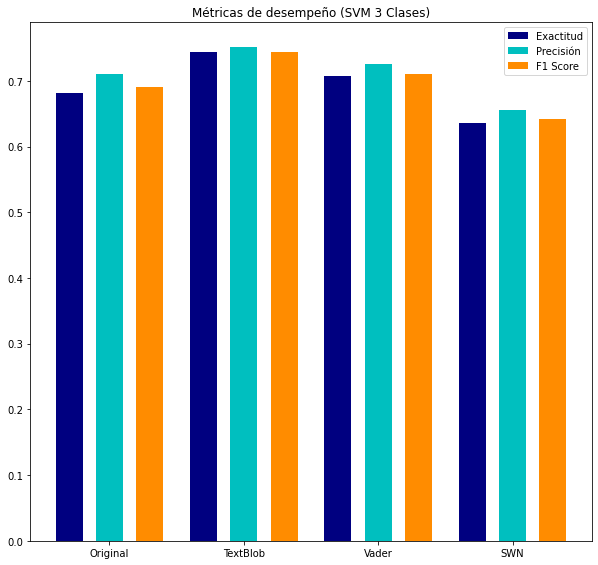

In [52]:
indices = ['Original', 'TextBlob', 'Vader', 'SWN']

Exactitud = [0.6810, 0.7442, 0.7073,0.6357]
Precision= [0.7106, 0.7514, 0.7252, 0.6551]
F1= [0.69, 0.7442, 0.7107, 0.6425]

numero_de_grupos = len(Exactitud)
indice_barras = np.arange(numero_de_grupos)

plt.figure(figsize=(12, 8))
plt.bar(indice_barras, Exactitud, 0.2, label="Exactitud", color="navy")
plt.bar(indice_barras + 0.3, Precision, 0.2, label="Precisión", color="c")
plt.bar(indice_barras + 0.6, F1, 0.2, label="F1 Score", color="darkorange")
plt.xticks(indice_barras + 0.3, ('Original', 'TextBlob', 'Vader', 'SWN'))

plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

plt.title('Métricas de desempeño (SVM 3 Clases)')

plt.show()